In [1]:
import numpy as np
import pandas as pd
from PyEMD import EMD, Visualisation
import scipy
import math
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

import ipdb

# 1. TCA function defining

In [2]:
def var_name(var, all_var=locals()):
    # get the name of the variable
    return [var_name for var_name in all_var if all_var[var_name] is var][0]


def np2csv(A):
    # store numpy to local csv file
    if type(A) == torch.Tensor:
        np.savetxt(var_name(A)+'.csv', A.detach().numpy(), delimiter=',')
    elif type(A) == np.ndarray:
        np.savetxt(var_name(A)+'.csv', A, delimiter=',')


def flat2vec(df):
    # df contains index and column tags
    # function: flatten a df (has 2 dimensions) to a 1D vector
    # the df data properties:
    # [[d1t1 d1t2 d1t3]
    #  [d2t1 d2t2 d2t3]
    #  [d3t1 d3t2 d3t3]]
    # dntn means day n time n
    
    # returned vector: 1D
    return np.array(df.loc[1:, 1:96].astype(float)).reshape(-1, 1).flatten()


def normalize(V):
    return ( V - min(V.flatten()) ) / ( max(V.flatten()) - min(V.flatten()) )

In [3]:
def sliding_window(T, T_org, seq_len, label_seq_len):

    # seq_len is equal to window_size
    # T (np.array) has dim: population, seq_len (window length)
    TT = T.reshape(-1, 1)
    K = TT.shape[0] - seq_len - label_seq_len + 1  # Li, et al., 2021, TRJ part C, pp. 8
    
    TT_org = T_org.reshape(-1, 1)

    # TT has dim: n, 1
    # assemble the data into 2D
    x_set = np.vstack(TT[i : K+i, 0] for i in range(seq_len)).T
    y_set = np.vstack(TT_org[i+seq_len : K+seq_len+i, 0] for i in range(label_seq_len)).T
    
    assert x_set.shape[0] == y_set.shape[0]

    # return size: [sequence_len, batch_size, inp/out dim = 1(default)]
    return x_set.T, y_set.T



In [4]:
def kernel(ker, X1, X2, gamma):
    K = None
    if not ker or ker == 'primal':
        K = X1
    elif ker == 'linear':
        if X2 is not None:
            # next line: K = X1.T@X2
            K = sklearn.metrics.pairwise.linear_kernel(np.asarray(X1).T, np.asarray(X2).T)
        else:
            K = X1.T@X1
    elif ker == 'rbf':
        if X2 is not None:
            K = sklearn.metrics.pairwise.rbf_kernel(np.asarray(X1).T, np.asarray(X2).T, gamma)
        else:
            K = sklearn.metrics.pairwise.rbf_kernel(np.asarray(X1).T, None, gamma)
    return K

In [5]:
class TCA:
    def __init__(self, kernel_type='primal', dim=30, lamb=1, gamma=1):
        '''
        Init func
        :param kernel_type: kernel, values: 'primal' | 'linear' | 'rbf'
        :param dim: dimension after transfer
        :param lamb: lambda value in equation
        :param gamma: kernel bandwidth for rbf kernel
        '''
        self.kernel_type = kernel_type
        self.dim = dim
        self.lamb = lamb
        self.gamma = gamma

    def fit(self, Xs, Xt):
        '''
        Transform Xs and Xt
        :param Xs: ns * n_feature, source feature
        :param Xt: nt * n_feature, target feature
        :return: Xs_new and Xt_new after TCA
        '''
        X = np.hstack((Xs.T, Xt.T))
        X /= np.linalg.norm(X, axis=1).reshape(-1, 1)
        m, n = X.shape
        ns, nt = len(Xs), len(Xt)
        e = np.vstack((1 / ns * np.ones((ns, 1)), -1 / nt * np.ones((nt, 1))))
        L = e * e.T
        L = L / np.linalg.norm(L, 'fro')
        H = np.eye(n) - 1 / n * np.ones((n, n))  # page 202
        K = kernel(self.kernel_type, X, None, gamma=self.gamma)
        n_eye = m if self.kernel_type == 'primal' else n
        a, b = np.linalg.multi_dot([K, L, K.T]) + self.lamb * np.eye(n_eye), np.linalg.multi_dot([K, H, K.T])
        w, V = scipy.linalg.eig(a, b)
        ind = np.argsort(w)
        A = V[:, ind[:self.dim]]
        Z = np.dot(A.T, K)
        Xs_new, Xt_new = Z[:, :ns].T, Z[:, ns:].T
        #ipdb.set_trace()
        Xs_new /= np.linalg.norm(Xs_new, axis=0)
        Xt_new /= np.linalg.norm(Xt_new, axis=0)
        return Xs_new, Xt_new, A

    def fit_predict(self, Xs, Ys, Xt, Yt):
        '''
        Transform Xs and Xt, then make predictions on target using 1NN
        :param Xs: ns * n_feature, source feature
        :param Ys: ns * 1, source label
        :param Xt: nt * n_feature, target feature
        :param Yt: nt * 1, target label
        :return: Accuracy and predicted_labels on the target domain
        '''
        Xs_new, Xt_new = self.fit(Xs, Xt)
        clf = KNeighborsClassifier(n_neighbors=1)
        clf.fit(Xs_new, Ys.ravel())
        y_pred = clf.predict(Xt_new)
        acc = sklearn.metrics.accuracy_score(Yt, y_pred)
        return acc, y_pred, Xs_new, Xt_new

**$X_{S, n_s\times n_{feature}}$**

**$X_{T, n_t\times n_{feature}}$**

**$X_{S, n_s\times n_{feature}}$** = **$((A^T)_{n_{feature}\times(n_s+n_t)}K_{(n_s+n_t)\times(n_s+n_t)})^T$**[:ns, :]

# 2. Learning Part

## 2.a. Load Data

In [23]:
weekdays = np.array([np.arange(2+7*i,7+7*i,1) for i in range(4)]).flatten()[:]

src_domain = np.array(pd.read_csv('data/siteM4_2168B_20210101_20210131.csv'))[weekdays[10:11], :]
data_target = np.array(pd.read_csv('data/siteM4_2188B_20210101_20210131.csv'))

date_choosen = 10
num_test_day = 0
tar_domain = data_target[weekdays[date_choosen:date_choosen+1 + num_test_day], :].reshape(-1, 96)
tgt_validation = tar_domain[1:num_test_day+1, :]

In [24]:
weekdays[10:15]

array([16, 17, 18, 19, 20])

In [25]:
weekdays[date_choosen:date_choosen+1 + num_test_day]

array([16])

In [26]:
np2csv(src_domain)
np2csv(tar_domain)

### 2.a.i. preview data

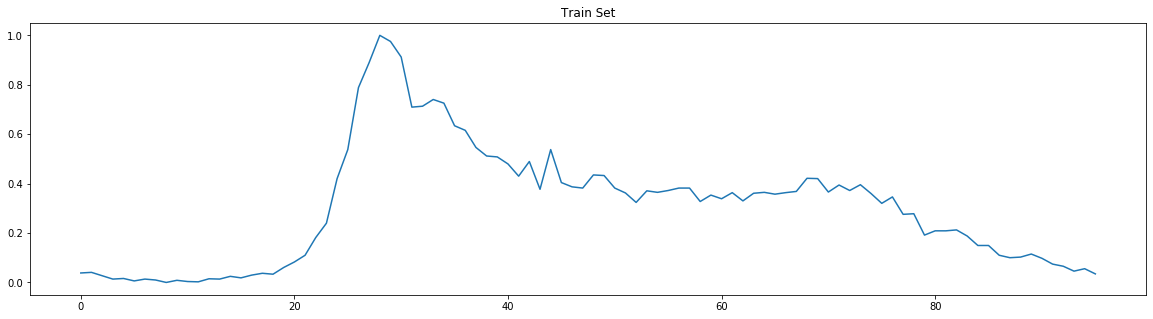

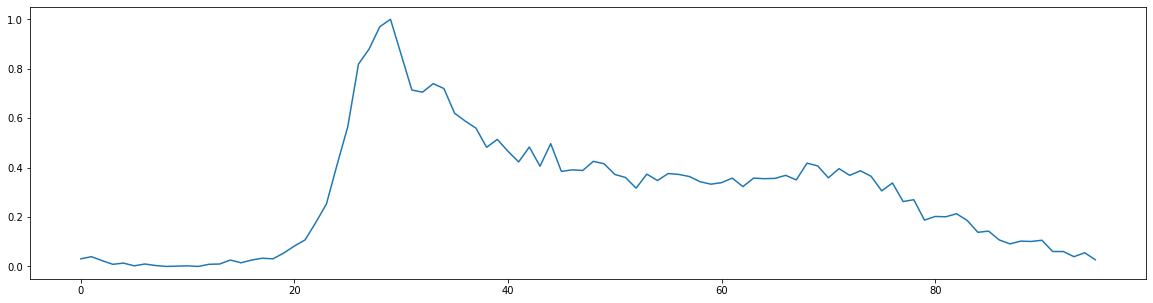

In [27]:
src_domain_emd = normalize(src_domain.flatten())
plt.figure(figsize=(20,5))
plt.plot(src_domain_emd)
plt.title('Train Set')

tar_domain_emd = normalize(tar_domain.flatten())
plt.figure(figsize=(20,5))
plt.plot(tar_domain_emd)


## 2.b. Extract Features using EMD

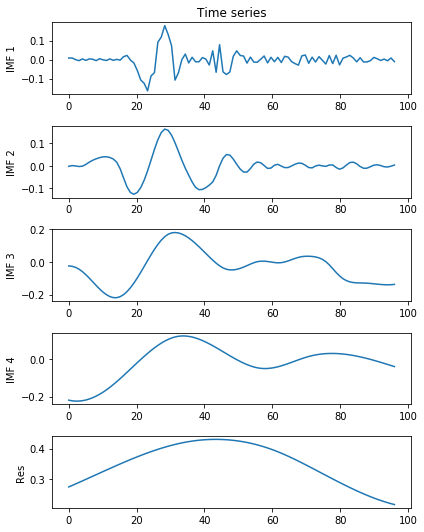

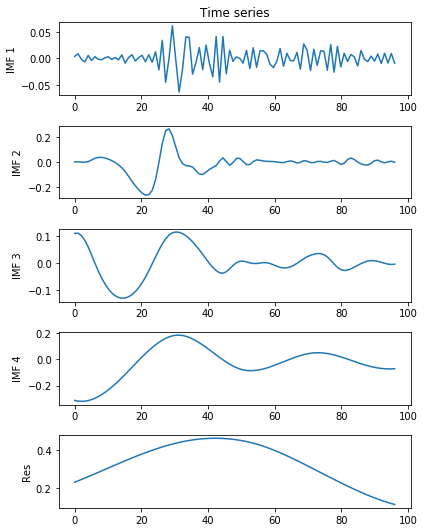

In [28]:
max_imf = 4

emd = EMD()
emd.emd(src_domain_emd, max_imf=max_imf)
imfs_src, res_src = emd.get_imfs_and_residue()
vis = Visualisation()
t_src = np.linspace(0, src_domain_emd.shape[0], src_domain_emd.shape[0])
vis.plot_imfs(imfs=imfs_src, residue=res_src, t=t_src, include_residue=True)
vis.show()

emd = EMD()
emd.emd(tar_domain_emd, max_imf=max_imf)
imfs_tar, res_tar = emd.get_imfs_and_residue()
vis = Visualisation()
t_tar = np.linspace(0, tar_domain_emd.shape[0], tar_domain_emd.shape[0])
vis.plot_imfs(imfs=imfs_tar, residue=res_tar, t=t_tar, include_residue=True)
vis.show()



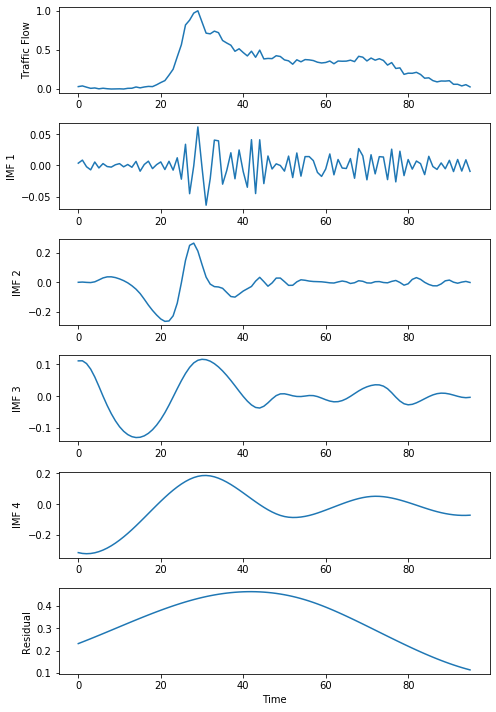

In [29]:
fig = plt.figure(figsize=[7,10])

ax1 = fig.add_subplot(611)
ax1.plot(tar_domain_emd)
ax1.set_ylabel('Traffic Flow')
#ax1.set_xlabel('Time')

ax2 = fig.add_subplot(612)
ax2.plot(imfs_tar[0,:])
ax2.set_ylabel('IMF 1')
#ax2.set_xlabel('Time')

ax3 = fig.add_subplot(613)
ax3.plot(imfs_tar[1,:])
ax3.set_ylabel('IMF 2')
#ax3.set_xlabel('Time')

ax4 = fig.add_subplot(614)
ax4.plot(imfs_tar[2,:])
ax4.set_ylabel('IMF 3')
#ax4.set_xlabel('Time')

ax5 = fig.add_subplot(615)
ax5.plot(imfs_tar[3,:])
ax5.set_ylabel('IMF 4')
#ax5.set_xlabel('Time')

ax6 = fig.add_subplot(616)
ax6.plot(res_tar)
ax6.set_ylabel('Residual')
ax6.set_xlabel('Time')

plt.tight_layout()

# date_choosen = 10

### 2.b.i. assemble Xs and Xt

Data type of **Xs**: [normalized_raw_data (fisrt row); emd_results (rest rows)]

In [30]:
Xs = np.concatenate([src_domain_emd.reshape(1, -1), imfs_src, res_src.reshape(1, -1)])
Xt = np.concatenate([tar_domain_emd.reshape(1, -1), imfs_tar, res_tar.reshape(1, -1)])
Xt_valid = Xt.copy()[:, 96:96*(num_test_day+1)]

In [31]:
print(Xs.shape, Xt.shape)

(6, 96) (6, 96)


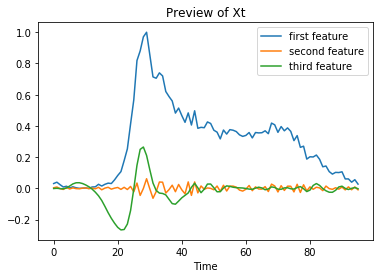

In [32]:
plt.plot(Xt[0, :], label='first feature')
plt.plot(Xt[1, :], label='second feature')
plt.plot(Xt[2, :], label='third feature')
plt.title('Preview of Xt')
plt.xlabel('Time')
plt.legend()

## 2.c. Hyperparameters
## 2.c. Hyperparameters
## 2.c. Hyperparameters
## 2.c. Hyperparameters
## 2.c. Hyperparameters
## 2.c. Hyperparameters
## 2.c. Hyperparameters

In [33]:
inp_dim = Xs.shape[0]
label_dim = Xs.shape[0]
label_seq_len = 1
# batch_size = full batch
seq_len = 10
reduced_dim = 1
hid_dim = 16
layers = 3
lamb = 3

hyper = {
    'inp_dim':inp_dim,
    'label_dim':label_dim,
    'label_seq_len':label_seq_len,
    'seq_len':seq_len,
    'reduced_dim':reduced_dim,
    'hid_dim':hid_dim,
    'layers':layers,
    'lamb':lamb}
hyper = pd.DataFrame(hyper, index=['Values'])

## 2.d. Apply Domain Adaptation using TCA (see part 1) upon Xs and Xt

In [34]:
hyper

,inp_dim,label_dim,label_seq_len,seq_len,reduced_dim,hid_dim,layers,lamb
Values,6,6,1,10,1,16,3,3


In [35]:
inp_dim -= reduced_dim
label_dim -= reduced_dim

In [36]:
tca = TCA(kernel_type='linear', dim=inp_dim, lamb=lamb, gamma=1)
Xs_new, Xt_new, A = tca.fit(Xs.T, Xt.T)  # input shape: ns, n_feature
Xs_new, Xt_new = Xs_new.T, Xt_new.T
Xt_valid_new = Xt_new.copy()[:, 96:96*(num_test_day+1)]
Xt_new = Xt_new.copy()[:, :96]

print(Xs_new.shape)
print(Xt_new.shape)

np2csv(Xt_valid_new)
np2csv(Xt_new)

(5, 96)
(5, 96)


In [37]:
Xs.shape

(6, 96)

In [38]:
XX = pd.DataFrame(np.vstack([Xs.flatten(), Xt.flatten()]).T, columns=['Xs', 'Xt'])
print(XX.corr())

XX_new = pd.DataFrame(np.vstack([Xs_new.flatten(), Xt_new_temp.flatten()]).T, columns=['Xs_new', 'Xt_new'])
print(XX_new.corr())

          Xs        Xt
Xs  1.000000  0.969757
Xt  0.969757  1.000000
         Xs_new   Xt_new
Xs_new  1.00000 -0.08577
Xt_new -0.08577  1.00000


### 2.d.i t-SNE

Text(0, 0.5, 'x2')

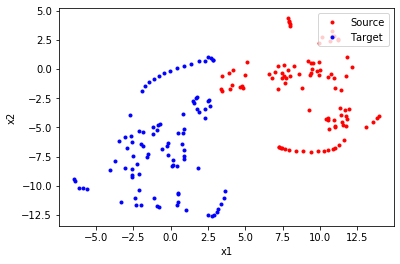

In [40]:
from sklearn.manifold import TSNE 
from pandas.core.frame import DataFrame

pca_tsne = TSNE(n_components=2)  
Xs_new_2D = pca_tsne.fit_transform(Xs_new.T)
Xt_new_2D = pca_tsne.fit_transform(np.hstack([Xt_new, Xt_valid_new]).T)
#Xt_valid_new_2D = pca_tsne.fit_transform(Xt_valid_new.T)

plt.plot(Xs_new_2D[:, 0], Xs_new_2D[:, 1], 'r.', label='Source')
plt.plot(Xt_new_2D[:, 0], Xt_new_2D[:, 1], 'b.', label='Target')
#plt.plot(Xt_valid_new_2D[:, 0], Xt_valid_new_2D[:, 1], 'g.', label='Validation')
plt.legend(loc=1)
plt.xlabel('x1')
plt.ylabel('x2')

Text(0, 0.5, 'x2')

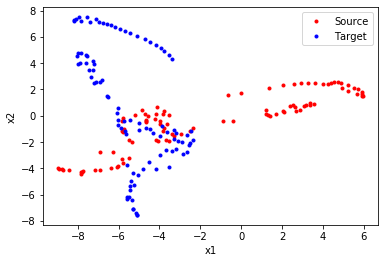

In [41]:
pca_tsne = TSNE(n_components=2)  
Xs_2D = pca_tsne.fit_transform(Xs.T)
Xt_2D = pca_tsne.fit_transform(Xt.T)
#Xt_valid_2D = pca_tsne.fit_transform(Xt_valid.T)

plt.plot(Xs_2D[:, 0], Xs_2D[:, 1], 'r.', label='Source')
plt.plot(Xt_2D[:, 0], Xt_2D[:, 1], 'b.', label='Target')
#plt.plot(Xt_valid_2D[:, 0], Xt_valid_2D[:, 1], 'g.', label='Validation')
plt.legend(loc=1)
plt.xlabel('x1')
plt.ylabel('x2')

In [42]:
day = 1
start = (day-1)*96
end = day*96

plt.rc('text', usetex=True)

In [110]:
pca_tsne = TSNE(n_components=2)  
Xs_2D = pca_tsne.fit_transform(Xs[:, start:end].T)
Xt_2D = pca_tsne.fit_transform(Xt[:, start:end].T)
#Xt_valid_2D = pca_tsne.fit_transform(Xt_valid.T)
np2csv(Xs_2D)
np2csv(Xt_2D)
#np2csv(Xt_valid_2D)



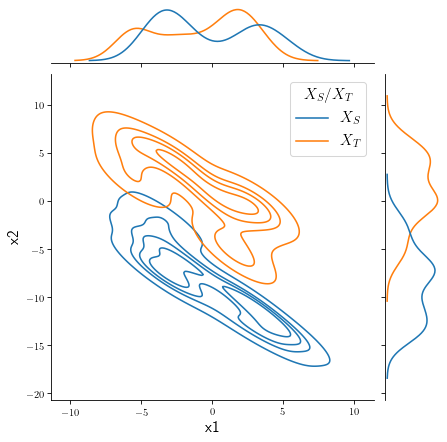

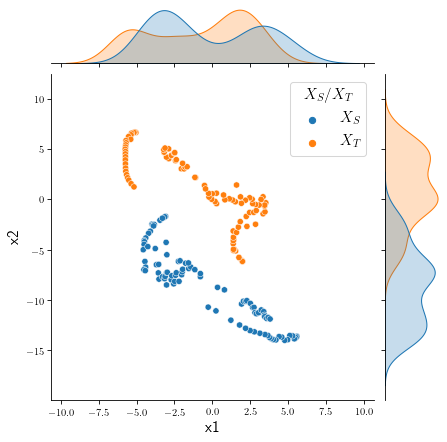

In [111]:
plt.rcParams["axes.labelsize"] = 15
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['legend.title_fontsize'] = 15
plt.rcParams['legend.loc'] = 'upper right'
plt.rcParams['figure.dpi'] = 75

Xs_2D_df = pd.DataFrame(Xs_2D, columns=['x1', 'x2'])
Xs_2D_df['$X_S/X_T$'] = '$X_S$'
Xt_2D_df = pd.DataFrame(Xt_2D, columns=['x1', 'x2'])
Xt_2D_df['$X_S/X_T$'] = '$X_T$'

X = pd.concat([Xs_2D_df, Xt_2D_df], axis=0)

sns.jointplot(data=X, x="x1", y='x2', hue="$X_S/X_T$", kind="kde", levels=5)
sns.jointplot(data=X, x="x1", y='x2', hue="$X_S/X_T$")

In [112]:
Xs_new_2D = pca_tsne.fit_transform(Xs_new[:, start:end].T)
Xt_new_2D = pca_tsne.fit_transform(Xt_new[:, start:end].T)
#Xt_valid_new_2D = pca_tsne.fit_transform(Xt_valid_new.T)
np2csv(Xs_new_2D)
np2csv(Xt_new_2D)
#np2csv(Xt_valid_new_2D)



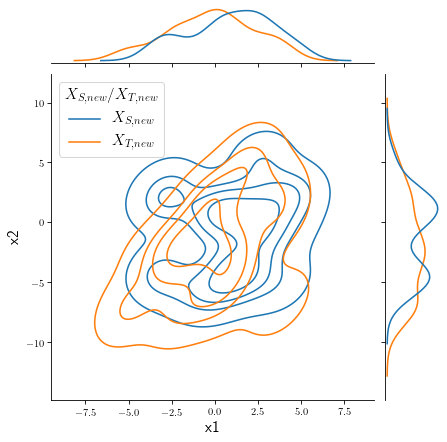

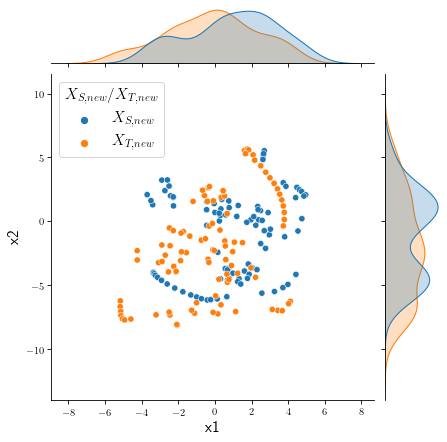

In [113]:
plt.rcParams["axes.labelsize"] = 15
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['legend.title_fontsize'] = 15
plt.rcParams['legend.loc'] = 'upper left'
plt.rcParams['figure.dpi'] = 75

Xs_new_2D_df = pd.DataFrame(Xs_new_2D, columns=['x1', 'x2'])
Xs_new_2D_df['$X_{S, new}/X_{T, new}$'] = '$X_{S, new}$'
Xt_new_2D_df = pd.DataFrame(Xt_new_2D, columns=['x1', 'x2'])
Xt_new_2D_df['$X_{S, new}/X_{T, new}$'] = '$X_{T, new}$'

X = pd.concat([Xs_new_2D_df, Xt_new_2D_df], axis=0)

sns.jointplot(data=X, x="x1", y="x2", hue="$X_{S, new}/X_{T, new}$", kind="kde", levels=5)
sns.jointplot(data=X, x="x1", y="x2", hue="$X_{S, new}/X_{T, new}$")


In [98]:
plt.rcParams.keys()

/opt/anaconda3/lib/python3.7/_collections_abc.py:705: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  return '{0.__class__.__name__}({0._mapping!r})'.format(self)


KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-7, 7],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
        